In [87]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf

In [88]:
def difference(series, order=1):
    """
    Apply differencing to a time series.
    If order > 1, difference repeatedly order times.
    """
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    """
    Invert a single differencing step.
    last_original is the last known observation before differencing.
    differenced is the differenced value to be inverted.
    """
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    """
    Create AR and MA features based on specific lists of lags.
    AR features: lagged values of the differenced series.
    MA features: lagged residuals (initialized as zeros and replaced after fitting).
    
    p_lags: list of AR lags (e.g. [1,3,5]) determined from PACF
    q_lags: list of MA lags (e.g. [2,4]) determined from ACF
    """
    # AR lags
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    # MA lags - initially zero or NaN, will be filled after we get residuals
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    # Combine AR and MA features
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar
    
    # Drop rows with NaN due to lagging
    X = X.dropna()
    y = series.loc[X.index]
    return X, y

def myARIMA(p, i, q, df):
    """
    Fit an ARIMA model to the given time series `df` using specified AR and MA lags.
    p: list of AR lags (from PACF significance)
    i: order of differencing
    q: list of MA lags (from ACF significance)
    df: Pandas Series of the time series values.
    
    Returns:
    model_dict: A dictionary containing the fitted model information.
    """
    # Ensure df is a series
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    original_series = df.copy()
    
    # Difference the series i times
    differenced_series = difference(df, order=i)
    
    # Create initial AR and placeholder MA features
    X, y = create_lag_features(differenced_series, p, q)
    
    # Initialize model
    model = LinearRegression()
    
    # If no MA terms, just fit once
    if len(q) == 0:
        model.fit(X, y)
        residuals = y - model.predict(X)
    else:
        # Step 1: Fit AR-only model
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        model.fit(X[ar_cols], y)
        residuals = y - model.predict(X[ar_cols])
        
        # Now fill in the MA features with lagged residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)
        
        # Drop rows with NaN after adding residuals
        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        
        # Refit with AR+MA
        model.fit(X, y)
        residuals = y - model.predict(X)
    
    # Calculate log-likelihood
    n = len(residuals)
    sigma2 = np.var(residuals)  # Variance of residuals
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)
        
    # Store model parameters
    coef = model.coef_
    intercept = model.intercept_
    
    # Determine how many historical values we need for forecasting
    # For AR, we need max(p); for MA, we need max(q)
    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)
    
    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'model': model,
        'intercept': intercept,
        'coef': coef,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,   # Storing the training features
        'y_train': y,   # Storing the training target
        # Store enough original and differenced values for future predictions
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [89]:
def ContextualisedARIMA(p, i, q, df, context_df=None):
    """
    Fit a linear ARIMA model with optional contextual features.
    
    Parameters:
    - p: list of AR lags
    - i: order of differencing
    - q: list of MA lags
    - df: Pandas Series of the time series values
    - context_df: DataFrame of contextual features (optional), indexed like df
    
    Returns:
    - model_dict: A dictionary with model information
    """
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
    
    original_series = df.copy()
    differenced_series = difference(df, order=i)
    
    # Create AR and MA features
    X_lags, y = create_lag_features(differenced_series, p, q)

    # Merge in context features if provided
    if context_df is not None:
        # Align and filter to only include the valid dates in X_lags
        context_features = context_df.loc[X_lags.index]
        X = pd.concat([X_lags, context_features], axis=1)
    else:
        X = X_lags

    # Initialize model
    model = LinearRegression()

    # If no MA terms, fit once
    if len(q) == 0:
        model.fit(X, y)
        residuals = y - model.predict(X)
    else:
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        base_cols = ar_cols
        if context_df is not None:
            base_cols += list(context_df.columns)

        model.fit(X[base_cols], y)
        residuals = y - model.predict(X[base_cols])

        # Fill MA features with lagged residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        # Drop rows with NaNs from shifting
        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Refit final model with all features
        model.fit(X, y)
        residuals = y - model.predict(X)

    n = len(residuals)
    sigma2 = np.var(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if p else 0
    max_q = max(q) if q else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'model': model,
        'intercept': model.intercept_,
        'coef': model.coef_,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'context_used': context_df is not None,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [90]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [91]:
def fit_model_with_bounds_and_intercept(X, y, bounds):
    """
    Fit a regression model with bounds on coefficients and include an intercept.
    """
    def objective_function(params):
        # Split coefficients and intercept
        coefficients = params[:-1]
        intercept = params[-1]
        predictions = np.dot(X, coefficients) + intercept
        residuals = y - predictions
        return np.sum(residuals**2)  # Minimize the sum of squared residuals

    # Initial guess (coefficients + intercept)
    initial_guess = np.zeros(X.shape[1] + 1)

    # Bounds for coefficients and intercept
    intercept_bound = (-np.inf, np.inf)  # Allow the intercept to vary freely
    all_bounds = bounds + [intercept_bound]

    # Minimize the objective function
    result = minimize(objective_function, initial_guess, bounds=all_bounds)
    return result.x[:-1], result.x[-1], result.fun


def myARIMA(p, i, q, df):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and stores a fitted Linear Regression model.
    """
    if not isinstance(df, pd.Series):
        df = pd.Series(df)

    original_series = df.copy()
    differenced_series = difference(df, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    # Bounds for coefficients (-1 to 1)
    bounds = [(-1, 1) for _ in range(X.shape[1])]

    if len(q) == 0:
        coef, intercept, residual_sum_of_squares = fit_model_with_bounds_and_intercept(X, y, bounds)
        residuals = y - (np.dot(X, coef) + intercept)
    else:
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]
        ar_coef, intercept, _ = fit_model_with_bounds_and_intercept(ar_X, y, [(-1, 1)] * len(ar_cols))
        residuals = y - (np.dot(ar_X, ar_coef) + intercept)

        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        coef, intercept, residual_sum_of_squares = fit_model_with_bounds_and_intercept(X, y, bounds)
        residuals = y - (np.dot(X, coef) + intercept)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    # Create and fit the Linear Regression model with optimized coefficients
    regression_model = LinearRegression(fit_intercept=True)
    regression_model.coef_ = coef
    regression_model.intercept_ = intercept

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,  # AR and MA coefficients
        'intercept': intercept,  # Intercept
        'model': regression_model,  # Store fitted Linear Regression model
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [92]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [93]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

Missing values: 1
date
2002-02-03    39.00
2002-02-10    38.29
2002-02-17    38.90
2002-02-24    40.72
2002-03-03    42.00
Name: PRC, dtype: float64


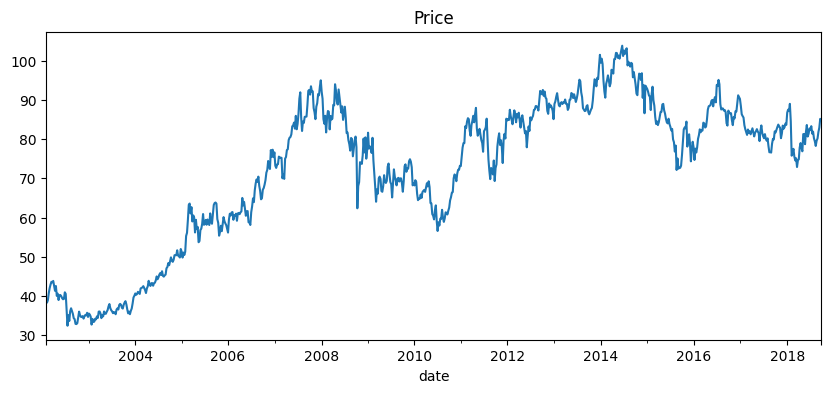

In [94]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)

# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
s = df['PRC']

f = 'W-SUN' # 'W-SUN' means week ending on Sunday
s = s.resample(f).last()

# check for missing values
print("Missing values:", s.isnull().sum())
# remove missing values
s = s.dropna()

start_date = '2002-1-30'
end_train_date = '2018-9-30'

# Filter the data according to the date range
s_train = s[(s.index >= start_date) & (s.index <= end_train_date)]
s_test = s[(s.index >= s_train.index[-1])]

print(s_train.head())
s_train.describe()

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [95]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [96]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


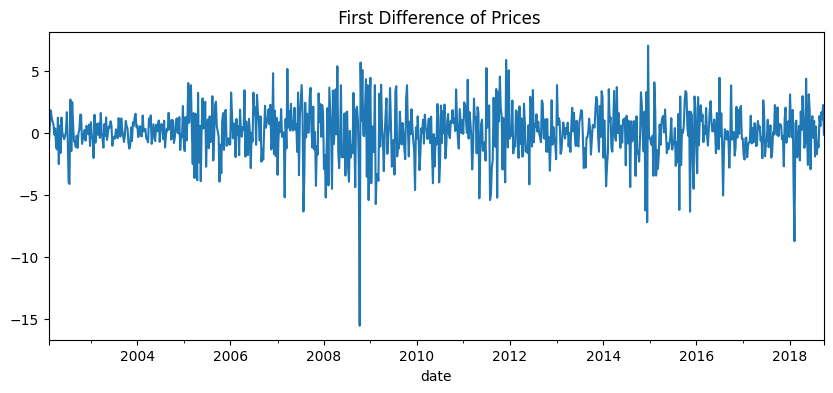

In [97]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

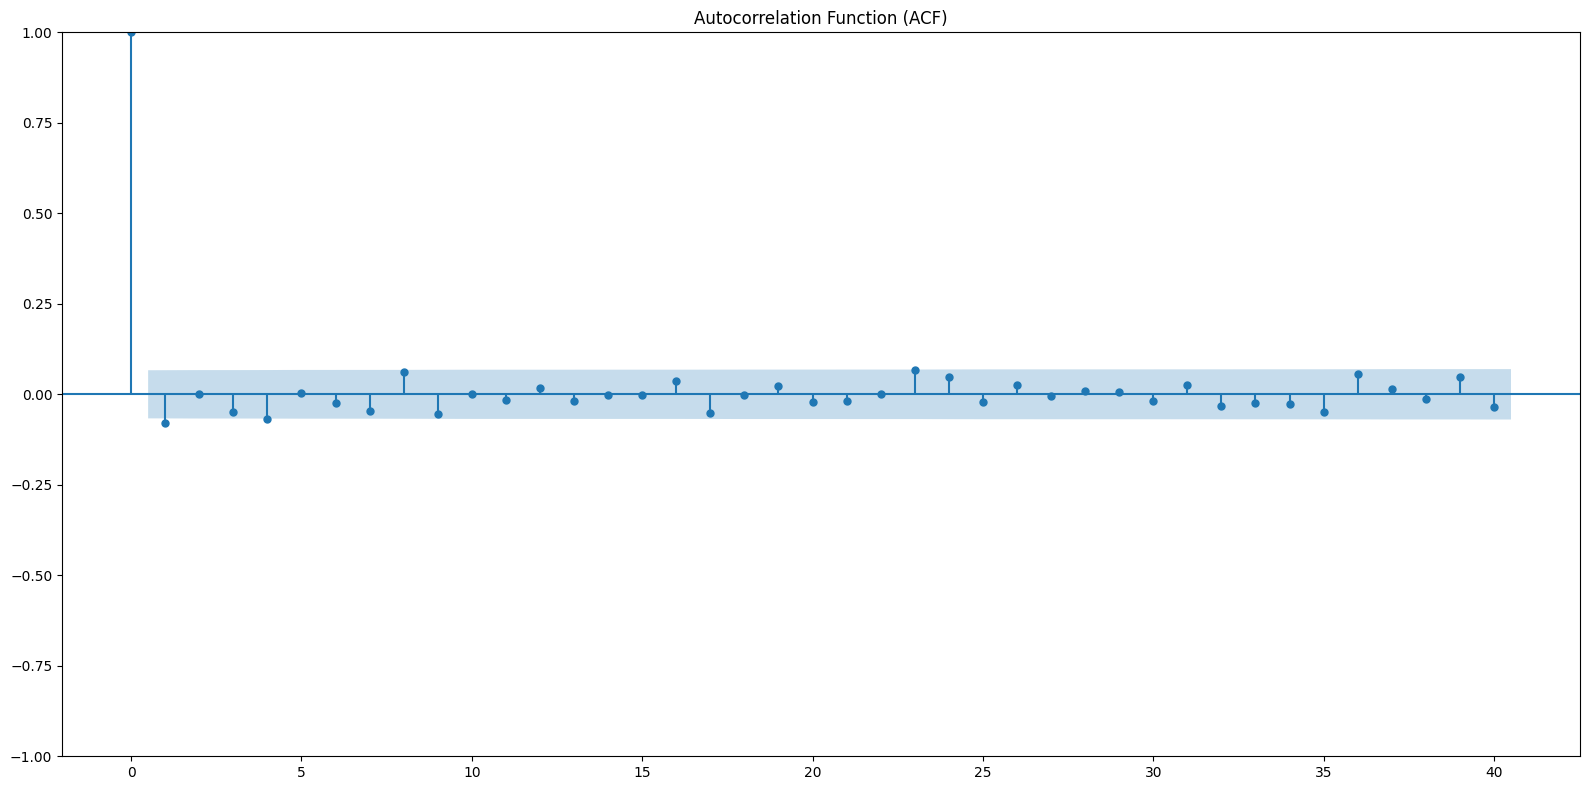

Significant ACF lags:
[1]


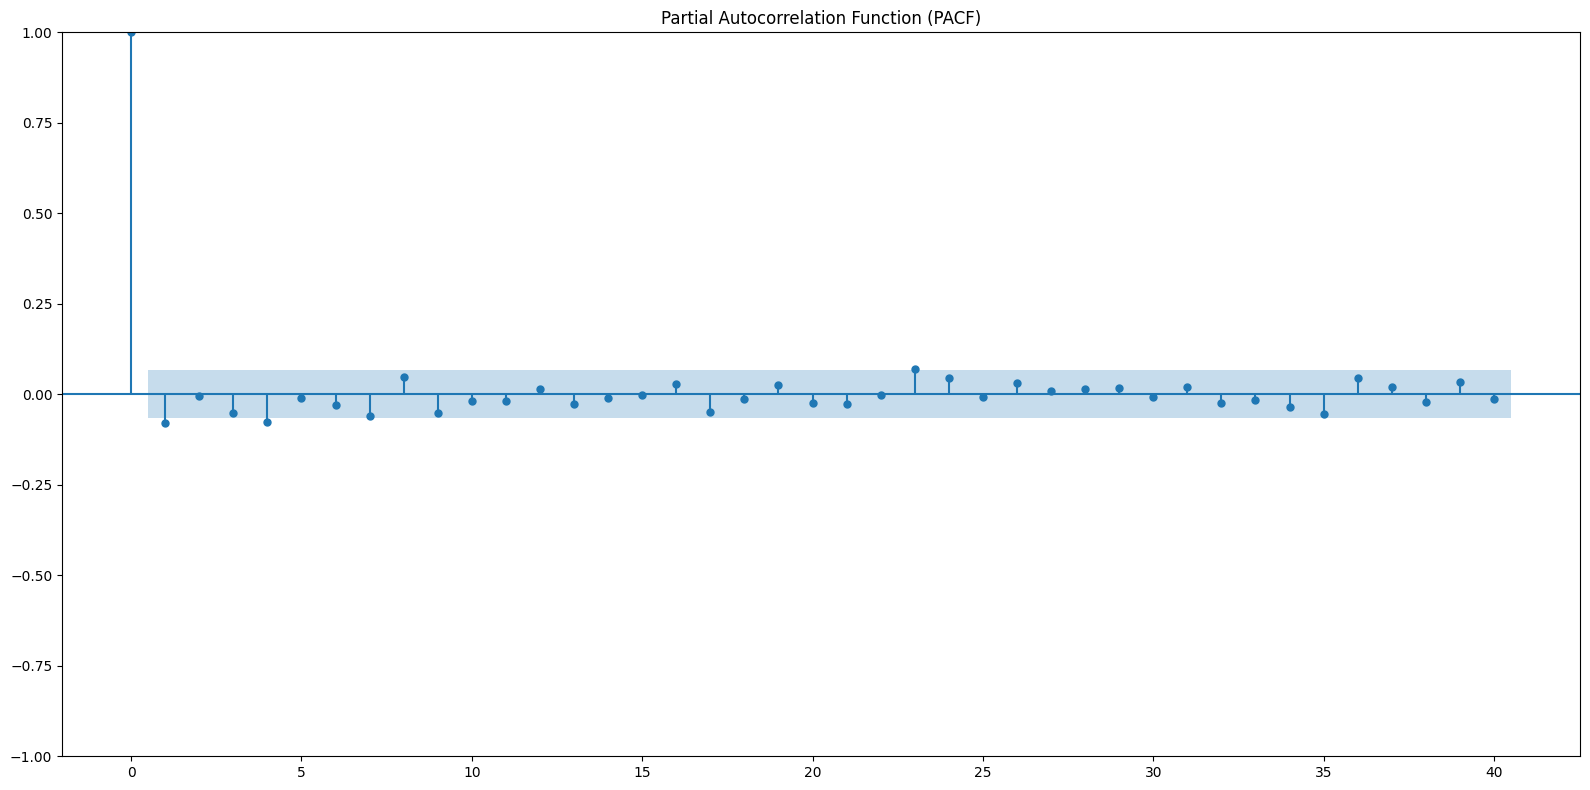

Significant PACF lags:
[1, 4, 23]


In [98]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [99]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,31))
q = [1,2,3]

# Fit the ARIMA model
model_dict = myARIMA(p=p, i=1, q=q, df=s_train)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


Learned Parameters:
Intercept: 0.1142
Coefficients:
lag_1: -1.0000
lag_2: 0.9065
lag_3: -0.5184
lag_4: -0.1766
lag_5: -0.0342
lag_6: 0.0014
lag_7: -0.1306
lag_8: 0.0124
lag_9: 0.0293
lag_10: -0.1393
lag_11: 0.0196
lag_12: -0.0106
lag_13: -0.0036
lag_14: -0.0644
lag_15: 0.0195
lag_16: 0.0305
lag_17: -0.0322
lag_18: -0.0811
lag_19: 0.0825
lag_20: 0.0041
lag_21: -0.0768
lag_22: 0.0180
lag_23: 0.0998
lag_24: 0.0980
lag_25: -0.0338
lag_26: 0.0268
lag_27: 0.0733
lag_28: -0.0065
lag_29: 0.0391
lag_30: 0.0025
ma_1: 0.9134
ma_2: -1.0000
ma_3: 0.5276


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


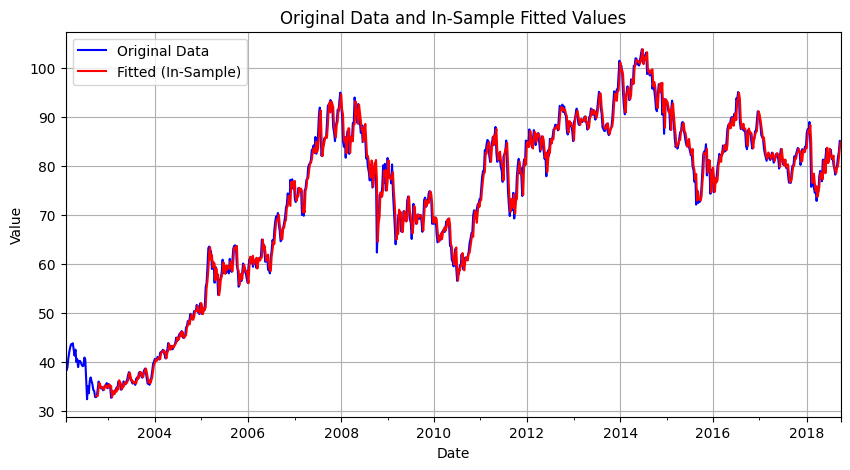

In [100]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without f

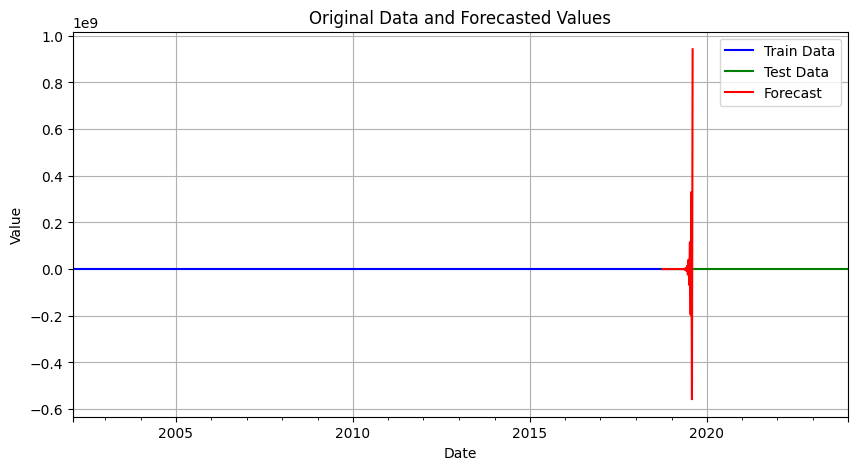

In [101]:
# Assume that model_dict, df, and forecast() are already defined.
forecast_steps = 45
preds = forecast(model_dict, forecast_steps)

# Get the last timestamp from the original series
last_date = s_train.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')
future_dates = pd.date_range(s_train.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [102]:
s_train = s_train.asfreq(f)  # 'D' stands for daily frequency
s_test = s_test.asfreq(f)  # 'D' stands for daily frequency

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(s_train, order=(30, 1, [1, 2, 3]))
model_fit = model.fit()

# Print the model summary
#print(model_fit.summary())

ar_params = model_fit.params.filter(like='ar.L')
ma_params = model_fit.params.filter(like='ma.L')

print(ar_params)
print(ma_params)




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1     0.564228
ar.L2     0.671237
ar.L3    -0.883744
ar.L4    -0.106554
ar.L5     0.073577
ar.L6    -0.028852
ar.L7    -0.102238
ar.L8     0.090241
ar.L9    -0.065297
ar.L10   -0.067228
ar.L11    0.053754
ar.L12    0.003102
ar.L13   -0.039173
ar.L14   -0.022189
ar.L15    0.040162
ar.L16    0.007312
ar.L17   -0.070458
ar.L18    0.000911
ar.L19    0.091537
ar.L20   -0.069616
ar.L21   -0.041234
ar.L22    0.068196
ar.L23    0.072457
ar.L24   -0.032196
ar.L25   -0.076900
ar.L26    0.073958
ar.L27    0.035721
ar.L28    0.004287
ar.L29    0.030458
ar.L30   -0.015738
dtype: float64
ma.L1   -0.647882
ma.L2   -0.631835
ma.L3    0.877687
dtype: float64


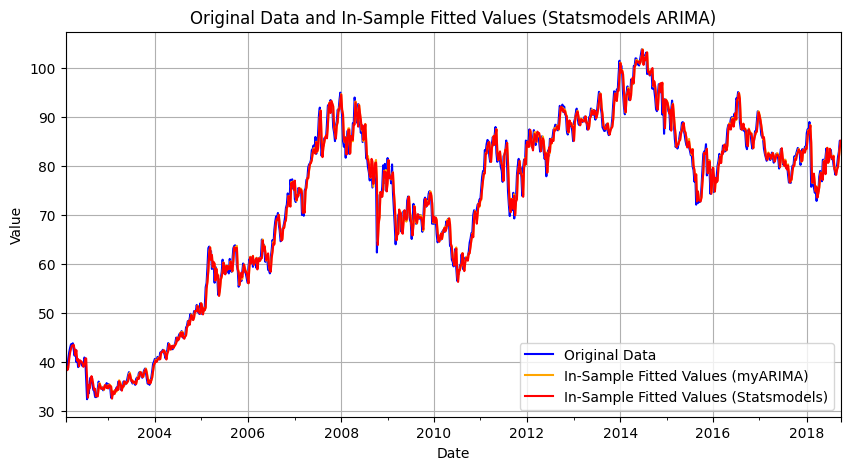

In [103]:
# Get the fitted values
fitted_values = model_fit.fittedvalues
fitted_values = fitted_values[1:]

# Plot the original data and the fitted values
plt.figure(figsize=(10, 5))
s_train.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='In-Sample Fitted Values (myARIMA)', color='orange')
fitted_values.plot(label='In-Sample Fitted Values (Statsmodels)', color='red')

plt.title("Original Data and In-Sample Fitted Values (Statsmodels ARIMA)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

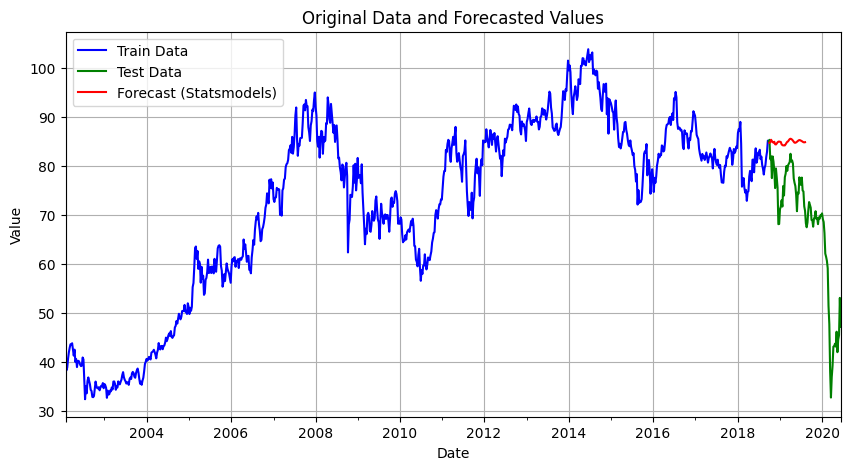

In [105]:
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean
#print(forecast_values)

# Generate future dates for the forecasted values
forecast_index = pd.date_range(s_train.index[-1], periods=forecast_steps + 1, freq=f)[1:]
forecast_series = pd.Series(forecast_values, index=forecast_index, name='Forecast')

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.iloc[:2*forecast_steps].plot(ax=ax, label='Test Data', color='green')
#mypred_series.plot(ax=ax, label='Forecast (myARIMA)', color='orange')
forecast_values.plot(ax=ax, label='Forecast (Statsmodels)', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
